In [0]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
# Any results you write to the current directory are saved as output.

In [0]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch.nn as nn
from tqdm import tqdm, trange
import time
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from sklearn.metrics import classification_report, accuracy_score

In [0]:
seed = 42

In [0]:
labels = pd.read_csv("./training-labels.csv")

In [5]:
labels.groupby(['Drscore']).size()

Drscore
0    9846
1    1027
2    2300
3     648
4     324
dtype: int64

In [0]:
labels_small = labels.sample(frac=0.1, random_state=seed)

In [7]:
labels_small.groupby(['Drscore']).size()

Drscore
0    998
1     83
2    242
3     56
4     35
dtype: int64

In [0]:
train_df, val_df = train_test_split(labels_small, test_size=0.2,stratify=labels_small['Drscore'], random_state = seed)

In [0]:
BATCH_SIZE = 2**3
NUM_WORKERS = 1
LEARNING_RATE = 5e-5
NUM_EPOCHS = 3
LOG_FREQ = 20
TIME_LIMIT = 9 * 60 * 60

In [0]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, mode):
        assert mode in ['train', 'val', 'test']

        self.df = dataframe
        self.mode = mode

        transforms_list = [
            transforms.Resize(512),
            transforms.CenterCrop(512)
        ]

        if self.mode == 'train':
            transforms_list.extend([
                transforms.RandomHorizontalFlip(),
                transforms.RandomChoice([
                    transforms.ColorJitter(0.2, 0.2, 0.2, 0.2),
                    transforms.RandomAffine(degrees=15, translate=(0.2, 0.2),
                                            scale=(0.8, 1.2), shear=15,
                                            resample=Image.BILINEAR)
                ])
            ])

        transforms_list.extend([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225]),
        ])
        self.transforms = transforms.Compose(transforms_list)

    def __getitem__(self, index):
        ''' Returns: tuple (sample, target) '''
        filename = self.df['Filename'].values[index]

        directory = 'test/Test' if self.mode == 'test' else 'train/output_combined2'
        sample = Image.open(f'./{directory}/{filename}')

        assert sample.mode == 'RGB'

        image = self.transforms(sample)

        if self.mode == 'test':
            return image
        else:
            return image, self.df['Drscore'].values[index]

    def __len__(self):
        return self.df.shape[0]


In [0]:
def GAP(predicts: torch.Tensor, confs: torch.Tensor, targets: torch.Tensor) -> float:
    ''' Simplified GAP@1 metric: only one prediction per sample is supported '''
    assert len(predicts.shape) == 1
    assert len(confs.shape) == 1
    assert len(targets.shape) == 1
    assert predicts.shape == confs.shape and confs.shape == targets.shape

    _, indices = torch.sort(confs, descending=True)

    confs = confs.cpu().numpy()
    predicts = predicts[indices].cpu().numpy()
    targets = targets[indices].cpu().numpy()

    res, true_pos = 0.0, 0

    for i, (c, p, t) in enumerate(zip(confs, predicts, targets)):
        rel = int(p == t)
        true_pos += rel

        res += true_pos / (i + 1) * rel

    res /= targets.shape[0]
    return res

In [0]:
class AverageMeter:
    ''' Computes and stores the average and current value '''
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0.0
        self.avg = 0.0
        self.sum = 0.0
        self.count = 0

    def update(self, val, n = 1) :
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


In [0]:
train_dataset = ImageDataset(train_df, mode='train')
val_dataset = ImageDataset(val_df, mode='val')
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                              shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE,
                             shuffle=False)

In [0]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [0]:
def train(train_loader, model, criterion, optimizer, epoch, logging = True):
    batch_time = AverageMeter()
    losses = AverageMeter()
    avg_score = AverageMeter()

    model.train()
    num_steps = len(train_loader)

    end = time.time()
    lr_str = ''

    for i, (input_, target) in enumerate(train_loader):
        if i >= num_steps:
            break

        output = model(input_.to(device))
        loss = criterion(output, target.to(device))

        confs, predicts = torch.max(output.detach(), dim=1)
        avg_score.update(GAP(predicts, confs, target))

        losses.update(loss.data.item(), input_.size(0))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_time.update(time.time() - end)
        end = time.time()

        if logging and i % LOG_FREQ == 0:
            print(f'{epoch} [{i}/{num_steps}]\t'
                        f'time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                        f'loss {losses.val:.4f} ({losses.avg:.4f})\t'
                        f'GAP {avg_score.val:.4f} ({avg_score.avg:.4f})'
                        + lr_str)
        if has_time_run_out():
            break

    print(f' * average GAP on train {avg_score.avg:.4f}')
    return avg_score.avg

In [0]:
def inference(data_loader, model):
    ''' Returns predictions and targets, if any. '''
    model.eval()

    activation = nn.Softmax(dim=1)
    all_predicts, all_confs, all_targets = [], [], []

    with torch.no_grad():
        for i, data in enumerate(data_loader):
            if data_loader.dataset.mode != 'test':
                input_, target = data
            else:
                input_, target = data, None

            output = model(input_.to(device))
            output = activation(output)

            confs, predicts = torch.topk(output, 1)
            all_confs.append(confs)
            all_predicts.append(predicts)

            if target is not None:
                all_targets.append(target)

    predicts = torch.cat(all_predicts)
    confs = torch.cat(all_confs)
    targets = torch.cat(all_targets) if len(all_targets) else None

    return predicts, confs, targets

In [0]:
def test(test_loader, model):
    predicts, confs, targets = inference(test_loader, model)
    predicts = predicts.cpu().numpy().flatten()
    targets = targets.cpu().numpy().flatten()
    return accuracy_score(targets, predicts)

In [0]:
def train_loop(epochs, train_loader, test_loader, model, criterion, optimizer, 
               validate=True):
    train_res = []

    test_res = []
    for epoch in trange(1, epochs + 1):
        start_time = time.time()
        train_acc = train(train_loader, model, criterion, optimizer, epoch, logging=False)

        train_res.append(train_acc)

        if validate:
            test_acc = test(test_loader, model)
            test_res.append(test_acc)
            
    return train_res, test_res

In [0]:
def has_time_run_out() -> bool:
    return time.time() - global_start_time > TIME_LIMIT - 9000

In [26]:
model = torch.hub.load('facebookresearch/WSL-Images', 'resnext101_32x8d_wsl')
# model = torchvision.models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 5)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

Using cache found in /root/.cache/torch/hub/facebookresearch_WSL-Images_master


In [0]:
global_start_time = time.time()

In [0]:
train_res, test_res = train_loop(NUM_EPOCHS, train_loader, val_loader, model, criterion, optimizer)

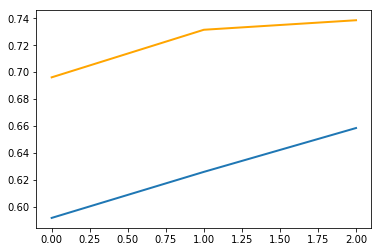

In [29]:
plt.plot(range(len(train_res)), train_res, lw=2)
plt.plot(range(len(train_res)), test_res, color='orange', lw=2)

In [0]:
torch.save(model.state_dict(), "./resnext101_32x8d_wsl.ptm")